In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src'))
from data_processing.preprocessing import *

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from utils.plotting import *
from model.rnn import *
from model.lstm import *
from model.metrics import *

In [2]:
# Liste des symboles des principales banques européennes
european_banks = [
    'BNP.PA',   # BNP Paribas
    'GLE.PA',   # Société Générale 
    'ACA.PA',   # Crédit Agricole 
    'HSBA.L',   # HSBC (UK)
    'BARC.L',   # Barclays (UK)
    'DBK.DE',   # Deutsche Bank (Germany)
    'UBSG.SW',  # UBS Group (Switzerland)
    'INGA.AS',  # ING Group (Netherlands)
    'ISP.MI',   # Intesa Sanpaolo (Italy)
    'SAN.MC',   # Banco Santander (Spain)
    'BBVA.MC'   # BBVA (Spain)
]

# à partir de 2013
start_date = '2013-01-01'
end_date = '2024-11-07'

data = prepare_stock_data(european_banks, start_date, end_date)

# Filtrer les colonnes associées à BNP.PA
bnp_data = data['BNP.PA']  # Cela sélectionne toutes les sous-colonnes sous 'BNP.PA'

# (Optionnel) Réinitialiser l'index pour une présentation plus lisible
bnp_data = bnp_data.reset_index()

bnp_data.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

bnp_data['Log Return'] = np.log(bnp_data['Adj Close']) - np.log(bnp_data['Adj Close'].shift(1))
bnp_data = bnp_data.interpolate(method='linear').ffill().bfill()
bnp_data

Téléchargement des données pour BNP.PA...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Téléchargement des données pour GLE.PA...
Téléchargement des données pour ACA.PA...


[*********************100%***********************]  1 of 1 completed


Téléchargement des données pour HSBA.L...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Téléchargement des données pour BARC.L...


Téléchargement des données pour DBK.DE...


[*********************100%***********************]  1 of 1 completed


Téléchargement des données pour UBSG.SW...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Téléchargement des données pour INGA.AS...
Téléchargement des données pour ISP.MI...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Téléchargement des données pour SAN.MC...
Téléchargement des données pour BBVA.MC...


[*********************100%***********************]  1 of 1 completed


Nombre de valeurs manquantes au début : 0
Nombre total de valeurs manquantes après traitement: 0


,Date,Adj Close,Close,High,Low,Open,Volume,Log Return
0,2013-01-02,22.753107,44.459999,44.564999,43.419998,43.930000,3604846.0,0.000000
1,2013-01-03,22.753107,44.459999,44.544998,44.014999,44.240002,1719620.0,0.000000
2,2013-01-04,22.714725,44.384998,44.720001,43.955002,44.360001,1969483.0,-0.001688
3,2013-01-07,23.136940,45.209999,46.064999,45.119999,45.250000,4186011.0,0.018417
4,2013-01-08,23.385141,45.695000,46.555000,45.064999,45.154999,4068024.0,0.010670
...,...,...,...,...,...,...,...,...
3038,2024-10-31,62.750000,62.750000,62.860001,60.599998,61.790001,7008244.0,-0.042892
3039,2024-11-01,63.040001,63.040001,63.419998,62.349998,62.570000,3008056.0,0.004611
3040,2024-11-04,62.869999,62.869999,63.439999,62.669998,62.990002,1950835.0,-0.002700
3041,2024-11-05,62.740002,62.740002,62.959999,62.020000,62.790001,2153744.0,-0.002070


In [3]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

scaler = MinMaxScaler(feature_range=(0, 1))
bnp_data['Adj Close'] = scaler.fit_transform(bnp_data[['Adj Close']])

In [ ]:
gap = 50  # Gap between each subset

# Calculate dynamic sizes
total_samples = len(bnp_data)
train_size = int(0.60 * total_samples)
test_size = int(0.18 * total_samples)
validation_size = int(0.18 * total_samples)

train,test,validation=data_splitting(bnp_data,train_size,test_size,validation_size,gap)

In [5]:
#data = pd.read_csv('../cleaned_data.csv', parse_dates=True)
#bnp_columns = data.filter(like='BNP.PA').columns
#data_bnp=data[bnp_columns]
#data_bnp.columns = data_bnp.iloc[0]
#data_bnp = data_bnp[2:].reset_index(drop=True)  # Enlève les lignes 0 et 1 et réindexe

<h2>LSTM Model</h2>

In [6]:
timesteps = 10
X, y = create_sequences(data_bnp_normalized,target_normalized, timesteps)

# Split into training and testing sets
split = int(0.6 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

split = int(0.5 * len(X_test))
X_test, X_validation = X_test[:split], X_test[split:]
y_test, y_validation = y_test[:split], y_test[split:]

# Build and train the LSTM model
model = build_lstm_model((X_train.shape[1], X_train.shape[2]))  # Input shape (timesteps, features)
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Calculate metrics
rmse = calculate_rmse(y_test_rescaled, y_pred_rescaled)
nse = calculate_nse(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse:.4f}")
print(f"NSE: {nse:.4f}")


NameError: name 'data_bnp_normalized' is not defined

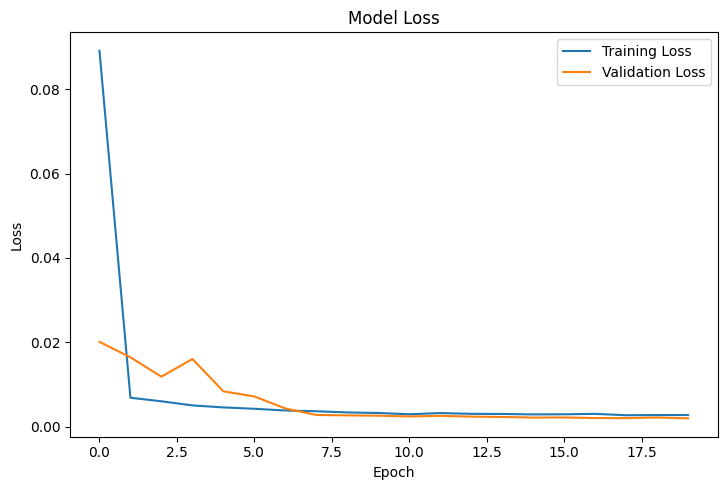

In [ ]:
plot_learning_curves(history)

<h2>RNN Model</h2>